In [ ]:
print("Nani")

: 

In [18]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='3ljF1rNyzuj2S-Lwn0L_29e4j_DfGKXG32uv1H4hplg9',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/identity/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.direct.au-syd.cloud-object-storage.appdomain.cloud')

bucket = 'work01-donotdelete-pr-vklfklyspvukzk'
object_key = 'Social Welfare Schemes.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head(10)


,finyear,lgdstatecode,statename,lgddistrictcode,districtname,schemecode,totalbeneficiaries,totalmale,totalfemale,totaltransgender,totalsc,totalst,totalgen,totalobc,totalaadhaar,totalmobilenumber
0,2025-2026,1,JAMMU AND KASHMIR,1,ANANTNAG,IGNDPS,108,72,36,0,0,3,104,1,108,69
1,2025-2026,1,JAMMU AND KASHMIR,1,ANANTNAG,IGNOAPS,8438,5059,3379,0,37,235,8083,83,8371,7190
2,2025-2026,1,JAMMU AND KASHMIR,1,ANANTNAG,IGNWPS,202,0,202,0,1,15,180,6,200,159
3,2025-2026,1,JAMMU AND KASHMIR,10,POONCH,IGNDPS,310,211,99,0,0,77,200,33,234,110
4,2025-2026,1,JAMMU AND KASHMIR,10,POONCH,IGNOAPS,5958,3958,2000,0,2,1347,4367,242,3875,2287
5,2025-2026,1,JAMMU AND KASHMIR,10,POONCH,IGNWPS,382,0,382,0,0,65,298,19,260,90
6,2025-2026,1,JAMMU AND KASHMIR,11,PULWAMA,IGNDPS,95,63,32,0,0,6,81,8,94,93
7,2025-2026,1,JAMMU AND KASHMIR,11,PULWAMA,IGNOAPS,5021,2911,2110,0,1,197,4443,380,5021,4935
8,2025-2026,1,JAMMU AND KASHMIR,11,PULWAMA,IGNWPS,304,0,304,0,0,20,260,24,304,258
9,2025-2026,1,JAMMU AND KASHMIR,12,RAJAURI,IGNDPS,78,52,26,0,5,5,68,0,72,3


In [19]:
df.groupby("schemecode")["totalbeneficiaries"].sum()


schemecode
IGNDPS       843945
IGNOAPS    22042306
IGNWPS      7005159
Name: totalbeneficiaries, dtype: int64

In [20]:
df.groupby("districtname")["totalbeneficiaries"].sum().sort_values(ascending=False)


districtname
PATNA                       303895
MADHUBANI                   282451
MUZAFFARPUR                 266767
MURSHIDABAD                 226207
PURBI CHAMPARAN             211211
                             ...  
PAKKE KESSANG                  438
UPPER DIBANG VALLEY            358
LAKSHADWEEP DISTRICT           256
BANDRA(MSD)                    243
NORTH AND MIDDLE ANDAMAN       141
Name: totalbeneficiaries, Length: 726, dtype: int64

In [21]:
df.groupby("schemecode")[["totalmale", "totalfemale", "totaltransgender"]].sum()


,totalmale,totalfemale,totaltransgender
schemecode,,,
IGNDPS,546833,296865,247
IGNOAPS,11350639,10689636,1751
IGNWPS,1,7005158,0


In [29]:
df["aadhaar_coverage"] = df["totalaadhaar"] / df["totalbeneficiaries"] * 100


In [30]:
df["missing_mobile"] = df["totalbeneficiaries"] - df["totalmobilenumber"]


In [25]:
print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum()) # Check for missing values
# Analyze the target variable distribution
print(df['schemecode'].value_counts())
 # Replace 'NSAP_SCHEME_COLUMN' with actual column name

     finyear  lgdstatecode          statename  lgddistrictcode districtname  \
0  2025-2026             1  JAMMU AND KASHMIR                1     ANANTNAG   
1  2025-2026             1  JAMMU AND KASHMIR                1     ANANTNAG   
2  2025-2026             1  JAMMU AND KASHMIR                1     ANANTNAG   
3  2025-2026             1  JAMMU AND KASHMIR               10       POONCH   
4  2025-2026             1  JAMMU AND KASHMIR               10       POONCH   

  schemecode  totalbeneficiaries  totalmale  totalfemale  totaltransgender  \
0     IGNDPS                 108         72           36                 0   
1    IGNOAPS                8438       5059         3379                 0   
2     IGNWPS                 202          0          202                 0   
3     IGNDPS                 310        211           99                 0   
4    IGNOAPS                5958       3958         2000                 0   

   totalsc  totalst  totalgen  totalobc  totalaadhaar  t

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identify features (X) and target (y)
# You'll need to inspect your dataset to find the actual column names
# Assume 'Scheme' is the target variable (the NSAP scheme)
# and other columns are features.
target_column = 'schemecode' # *YOU MUST REPLACE THIS WITH THE ACTUAL COLUMN NAME*
X = df.drop(columns=[target_column])
y = df[target_column]

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object', 'category']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore') # handle_unknown='ignore' for new categories in test set

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# stratify=y is important for multi-class classification to maintain class proportions

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# You can choose a classifier. Let's start with Logistic Regression for simplicity.
# For better performance, you might try RandomForestClassifier or GradientBoostingClassifier.
classifier = LogisticRegression(max_iter=1000, random_state=42) # Increased max_iter for convergence

# Create the full pipeline: preprocessor + classifier
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', classifier)])

# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['lgdstatecode', 'lgddistrictcode', 'totalbeneficiaries', 'totalmale',
       'totalfemale', 'totaltransgender', 'totalsc', 'totalst', 'totalgen',
       'totalobc', 'totalaadhaar', 'totalmobilenumber', 'aadhaar_coverage',
       'missing_mobile'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['finyear', 'statename', 'districtname'], dtype='object'))])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

Accuracy: 0.8704

Classification Report:
              precision    recall  f1-score   support

      IGNDPS       0.82      0.90      0.86       141
     IGNOAPS       1.00      0.88      0.93       146
      IGNWPS       0.81      0.83      0.82       145

    accuracy                           0.87       432
   macro avg       0.88      0.87      0.87       432
weighted avg       0.88      0.87      0.87       432



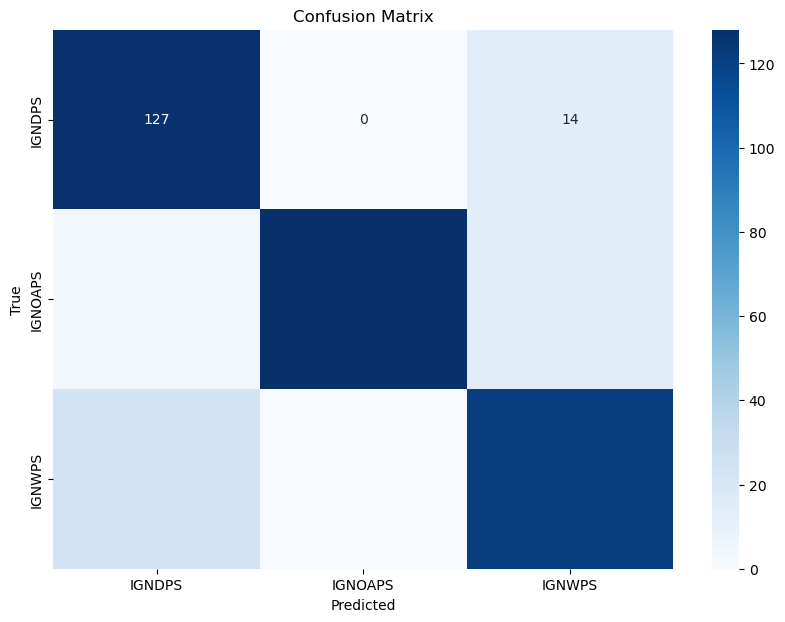

In [28]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_) # Use model.classes_ after fitting
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [32]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')


0.9771661471561234

In [33]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("CV Accuracy: %.4f ± %.4f" % (scores.mean(), scores.std()))


CV Accuracy: 0.8716 ± 0.1197


In [34]:
print(df['schemecode'].value_counts(normalize=True))


schemecode
IGNOAPS    0.339054
IGNWPS     0.335343
IGNDPS     0.325603
Name: proportion, dtype: float64


In [36]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier())
])


In [37]:
model = pipeline.named_steps['model']


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

feat_imp = pd.Series(model.feature_importances_, index=X_train.columns)
feat_imp = feat_imp.sort_values(ascending=False)

feat_imp.plot(kind='bar', figsize=(12,6))
plt.title('Feature Importances')
plt.show()


ValueError: Length of values (769) does not match length of index (17)

In [39]:
print(pipeline.named_steps)


{'scaler': StandardScaler(), 'model': RandomForestClassifier()}
